# Code for imperfect testing model based on BHM (2020) and user interface

### 1. What does this code do?

This code extends (and replicates Figure 6 in) Berger, Herkenhoff, Mongey (2020) - *An SEIR Infectious Disease Model with Testing and Conditional Quarantine" by introducing imperfect testing through <1 sensitivity and specificity.

To run the model for various parameter values, follow these instructions:
1. Scroll down to the indicated 'initialization cell' below, place cursor inside the cell, then press Ctrl+Enter.
    - This will compile some code and present the baseline calibration of the model
1. Click the button marked **[Run model]**
    - The code will take ~45-90s to run the model, and then display **"Done solving model"**
1. Click the button marked **[Show panel chart]** to display the figure
    - Accompanying the figure will be a slider for $\tau \in [0,0.05]$ (from zero to 10 times the value used in the paper), that can be moved to change the plot

Below we describe other parameters. To change other parameters refresh this page in your browser. Repeat the above and then before pressing **[Run model]**, choose alternative values for model parameters.

In case you want to see the raw contents of the cells, please choose 'Raw NB convert' for cell type. For executable code, change back to 'code'!

**To download the underlying code, please ...

### 2. What can I change?

- There are two sets of parameters that the user can change

#### 2.1 Preset parameters

The first set appear in Table 4 of the paper, and below are divided into three blocks
1. **Quarantine parameters**
    - $\xi^u\geq 0$ 
        - Baseline rate of quarantine that is used in the *Common quarantine* case
    - $\lambda^Q/\lambda\in[0,1]$ 
        - Effectiveness of quarantine. If equal to 1, then quarantine has no effect. We suggest in the paper that for Wuhan this is around 0.10, and use 0.50 as our baseline for counterfacutals
    - $A_{rel}\in[0,1]$ 
        - Relative productivity of asymptomatic quarantined individuals to asymptomatic non-quarantined individuals. 
             $$ Y_t = M_t^{A,NQ} + A_{rel}\times M_t^{A,Q} $$
        - If this is lower, then *Common quarantine* policy will lead to larger declines in output relative to *Targeted quarantine* policies.
1. **Disease parameters**
    - Number of initial infections in the US population
    - $\pi^D$ 
        - Rate at which *symptomatic* individuals die from the virus.
1. **Timing parameters**
    - Date of vaccine - In the paper we set this to 500 days
    - $1/\delta$
        - Gives the number of days that it takes, on average, to show symptoms once infected with the virus
    - $1/\omega^R$
        - Gives the number of days that it takes, on average, to recover from the virus
1. **Contagion parameters**
    - $R_0$
        - This is the baseline transmission rate. In the code $\rho^S$---the probability of infection conditional on meeting---is chosen to imply this level of $R_0$
   - $\rho^A/\rho^S$
        - This is measures the relative infectiousness of asymptomatic individuals. A meeting with a symptomatic individual results in infection with probability $\rho^S$. If $\rho^A/\rho^S=0.5$, then half as many meetings with asymptomatic individuals result in infection. In the paper we simply set this to 1.
    
#### 2.2 Policy parameters

The second set appear in Tables 5 and 6 of the paper, these are the very simply 'policy parameters' $\tau\geq 0$ and $\Delta\in[0,1]$ which represent the rate of daily testing and the slackening of quarantine measures that we use to construct our counterfactual.

- Chooses one of the two parameters to *Slide over*
- Set the range for the other parameter. 
    - When sliding over $\Delta$, the *upper value* is always 1, which represents no slackening of quarantine. User then chooses the *lower bound*.
    - When sliding over $\tau$, the *lower value* is always 0, which represents no testing. User then chooses the *upper bound*.
    - In both cases the grid of parameters that are considered is evenly spaced and has 10 points.
- Proceed as above: Click **[Run model]**, wait until it displays **"Done solving model"**, then click **[Show panel chart]**



#### 2.3 Optimization parameters

The third set of parameters sets decision variables for optimization. 

##### 2.3.1 Lockdown rate

These decision variables are used to optimize for lockdown profile. The variables are given as a vector of integers, where each integer creates a new decision variable, that adjusts the strength of lockdown starting from **simulation day given by the integer**. The optimization algorithm well then search for best values for lockdown rates for these days.

In [12]:
# Please give the lockdown policy making days for lockdown rate.
termination_step = 3
nsga2_pop_size = 14 # low for debugging
mutation_parameter = 8 # smaller value -> larger mutation

lockdown_policy_days = [15, 30, 60, 90, 120, 150, 200]
lockdown_policy_lower_limits = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lockdown_policy_upper_limits = [0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005]


In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# INSTRUCTIONS: Click to place cursor in this box, and then press Ctrl+Enter
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([5,7])")

<IPython.core.display.Javascript object>

In [3]:
from model_code import *
from jupyterWidgets import *

import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from policy_epidemic_model_code import *
import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume


In [4]:
# Toggle on/off the raw code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to switch on/off the raw code"></form>''')

In [4]:
display(paramsPanel)

In [ ]:
# OPTIMIZATION


termination = get_termination("n_gen", termination_step) # Use small value for debugging - large for runs

corona_model = optimizable_corona_model(ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value, rel_ρ.value, δ_param.value, \
                 ωR_param.value, π_D.value, R_0.value, rel_λ.value, initial_infect.value)

class COVID_policy(Problem):

    def __init__(self, model, policy_control_days):

        self.model = model
        self.policy_control_days = policy_control_days

        super().__init__(n_var=len(policy_control_days),
                         n_obj=2,
                         n_constr=0,
                         xl=np.array(lockdown_policy_lower_limits),
                         xu=np.array(lockdown_policy_upper_limits))

    def _evaluate(self, x, out, *args, **kwargs):

        f1 = []
        f2 = []
        for j in range(len(x[:,1])):  # evaluate f1 and f2 for each individual
            # TODO:  implement calculation of f1, f2 for all individuals (represented by rows in x)

            policy = {} # this will hold the policy in format suitable for input to the epidemic model
            for (i, t) in enumerate(self.policy_control_days):
                policy[t] = x[j,i]

            Reported_D, Notinfected_D, Unreported_D, Infected_D, False_pos, False_neg, Recovered_D, Dead_D, Infected_T, Infected_not_Q, Infected_in_Q, Y_D, M_t, Y_total \
                = self.model.solve_case(self.model.baseline, policy)

            # objectives scaled to roughly same scale
            #f1.append(Dead_D[-1]*self.model.pop/1000)
            #f2.append(-Y_total/(14*365*self.model.T_years)) # algorithm minimizes, Y_total needs to be max'd -> negative

            f1.append(Dead_D[-1])
            f2.append(-Y_total) # algorithm minimizes, Y_total needs to be max'd -> negative


        out["F"] = np.column_stack([f1, f2])
        #out["G"] = np.column_stack([g1, g2])


    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2

        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2

        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)

    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = COVID_policy(corona_model, lockdown_policy_days)

algorithm = NSGA2(
    pop_size=nsga2_pop_size,
    n_offsprings=6,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=mutation_parameter),
    eliminate_duplicates=True
)

print("Starting optimization: please wait...")
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               #pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)

with open('results/optimization_result.txt', 'w') as f:
    print(res.X, file=f)

with open('results/optimization_objectives.txt', 'w') as f:
    print(res.F, file=f)

print("Run complete and results saved.")

Starting optimization: please wait...
n_gen |  n_eval |     igd      |      gd      |      hv     
    1 |      14 |  1.02171E+04 |  1.02185E+04 |  8.27873E+03
    2 |      20 |  1.02171E+04 |  1.02186E+04 |  8.27873E+03


In [14]:
res.F

array([[ 0.51988164, -0.99998696],
       [ 0.51067824, -0.99968589],
       [ 0.51449967, -0.99981166],
       [ 0.51130376, -0.99970655],
       [ 0.51603638, -0.99986193],
       [ 0.51886397, -0.99995398],
       [ 0.51967019, -0.99998011],
       [ 0.5178972 , -0.99992257],
       [ 0.51847026, -0.9999412 ],
       [ 0.51748234, -0.99990908],
       [ 0.51671632, -0.99988412],
       [ 0.51606426, -0.99986284],
       [ 0.51703347, -0.99989446],
       [ 0.51085915, -0.99969187]])

In [6]:
restest = np.array([[4.99892470e-03, 1.68269206e-03, 7.02675066e-04, 1.17497432e-03,
        9.89311671e-04, 3.28771202e-04, 1.52717702e-03],
       [2.34731384e-07, 2.51227272e-03, 1.04248416e-05, 4.05161422e-03,
        8.44776666e-04, 3.74514189e-04, 2.94175679e-03],
       [6.98112309e-04, 1.49360360e-03, 5.41354535e-04, 2.98479062e-03,
        4.93648011e-04, 1.33179914e-03, 3.12751373e-03],
       [1.43995044e-03, 2.53069596e-04, 2.30385020e-03, 3.03199927e-04,
        1.32243825e-03, 2.45728800e-03, 3.79005223e-03],
       [2.73240453e-03, 3.23974052e-03, 4.41272965e-03, 4.39257877e-03,
        9.57291491e-04, 4.23143383e-04, 9.41590823e-04],
       [4.61715101e-03, 1.68269206e-03, 7.02675066e-04, 1.17497432e-03,
        9.89311671e-04, 3.28771202e-04, 1.52717702e-03],
       [3.32369054e-03, 9.74256750e-04, 5.40614000e-04, 2.98479062e-03,
        9.74854610e-04, 9.83179788e-04, 4.30034467e-03],
       [1.63514387e-03, 9.74256750e-04, 2.18742333e-03, 2.83830029e-03,
        1.33055310e-03, 1.01005016e-03, 4.30034467e-03],
       [3.12849711e-03, 2.53069596e-04, 1.00534080e-03, 3.19382622e-04,
        9.66739759e-04, 2.43041765e-03, 3.79005223e-03],
       [2.34773917e-03, 2.53069596e-04, 2.30385020e-03, 2.97358050e-03,
        1.32243825e-03, 1.98842442e-03, 2.84785747e-03],
       [3.28863518e-04, 1.37240251e-03, 6.53608985e-04, 2.98479062e-03,
        8.56550598e-04, 9.84276225e-04, 2.94177521e-03],
       [2.05422370e-03, 2.52490047e-03, 8.21871156e-05, 4.39257877e-03,
        9.62936811e-04, 3.74245034e-04, 2.97835688e-03],
       [3.77043164e-03, 3.22149439e-03, 4.42193340e-04, 1.20070268e-03,
        9.99461998e-04, 9.93116363e-04, 7.97248941e-04],
       [3.79197959e-03, 3.22149439e-03, 3.13269201e-04, 1.20070268e-03,
        9.99461998e-04, 9.93116363e-04, 7.97248941e-04]])

In [60]:
lockdownpolicy_list = []
for j, x in enumerate(res.X):
    policy = {} # this will hold the policy in format suitable for input to the epidemic model
    for (i, t) in enumerate(lockdown_policy_days):
        policy[t] = x[i]

    lockdownpolicy_list.append(policy)


In [7]:
# Test implementation - doesn't use optimizer results
lockdownpolicy_list = []
for j, x in enumerate(restest):
    policy = {} # this will hold the policy in format suitable for input to the epidemic model
    for (i, t) in enumerate(lockdown_policy_days):
        policy[t] = x[i]

    lockdownpolicy_list.append(policy)


In [9]:
ff = generate_plots(Δ.value, τ.value, test_sens.value, test_spec.value, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value, lockdownpolicy_list)

Creating a corona model with testing rate =  0.0  sensitivity =  0.95  and specificity =  0.95


In [10]:
ff

<p><center><span style="color:red">1. No testing - Common quarantine, Red [dotted]</span> , <span style="color:blue">2. Testing - Targeted quarantine: Blue [dashed]</span></center></p>

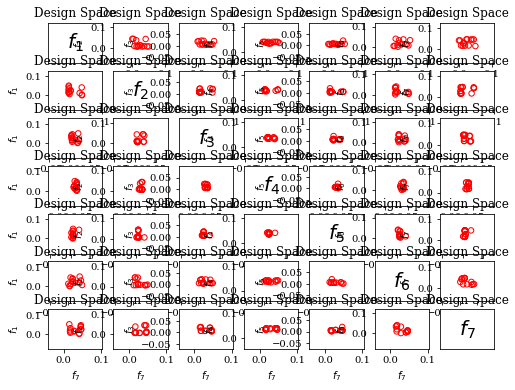

In [20]:
# Design Space
plot = Scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
#plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
#plot.apply(lambda ax: ax.set_xlim(0.0, 5.0))
#plot.apply(lambda ax: ax.set_ylim(0.0, 0.2))
plot.show()

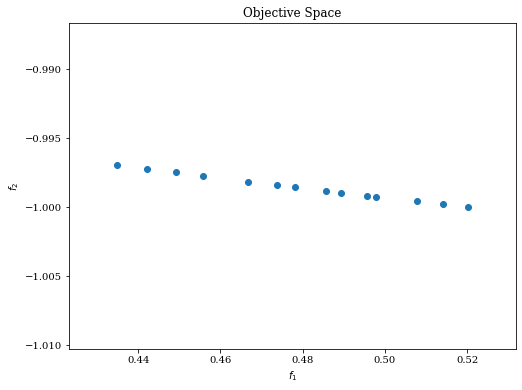

In [21]:
# Objective Space
plot = Scatter(title = "Objective Space")
plot.add(res.F)
plot.do()
#plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

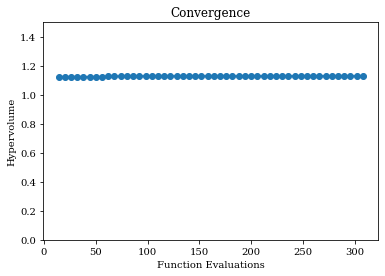

In [40]:
# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o')
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.ylim([0.0,1.5])
plt.show()

In [38]:
n_evals

array([ 14,  20,  26,  32,  38,  44,  50,  56,  62,  68,  74,  80,  86,
        92,  98, 104, 110, 116, 122, 128, 134, 140, 146, 152, 158, 164,
       170, 176, 182, 188, 194, 200, 206, 212, 218, 224, 230, 236, 242,
       248, 254, 260, 266, 272, 278, 284, 290, 296, 302, 308])

In [39]:
hv

[1.125442927204628,
 1.1254438205160502,
 1.1254438205160502,
 1.1254454934176408,
 1.1254609523894368,
 1.1254610879779634,
 1.1254611635677423,
 1.1254618954866176,
 1.1277154916887808,
 1.1277144456247863,
 1.1285348805255628,
 1.1291016005039132,
 1.1291045972092817,
 1.1291050706895722,
 1.12910521115709,
 1.1293474390198406,
 1.1296445580692285,
 1.1296467987225325,
 1.1296472281787386,
 1.1296474085195523,
 1.1296484272733636,
 1.129648193833299,
 1.129647715396172,
 1.129647715396172,
 1.1296480795189492,
 1.1296580094667978,
 1.1296582436317089,
 1.1296583450503124,
 1.1296583450503124,
 1.1296575433074714,
 1.1296575433074714,
 1.1300509795089568,
 1.1300509795089568,
 1.1300509795089568,
 1.1300507628892709,
 1.130049601774476,
 1.1300504323502143,
 1.130050183138528,
 1.1300510072649537,
 1.130050941663731,
 1.1300515289840642,
 1.1300515289840642,
 1.1300515289840642,
 1.1300515289840642,
 1.130050792101192,
 1.1300512370199811,
 1.130053436869082,
 1.1300534734807672,
 1.

In [ ]:
res.history[0].pop.get("X")

In [ ]:
display(run_box)

In [ ]:
τ_list = np.arange(0., τ_max.value + τ_step.value, τ_step.value)
Δ_list = np.arange(Δ_min.value, 1. + Δ_step.value, Δ_step.value)

if slide_var.value == 1:
    f = generate_plots(Δ.value, τ_list, test_sens.value, test_spec.value, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value)
elif slide_var.value == 2:
    f = generate_plots(Δ_list, τ.value, test_sens.value, test_spec.value, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value)
elif slide_var.value == 3:
    test_sens_list = np.arange(test_sens_min.value, test_sens_max.value + test_sens_step.value, test_sens_step.value)
    f = generate_plots(Δ.value, τ.value, test_sens_list, test_spec.value, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value)
elif slide_var.value == 4:
    test_spec_list = np.arange(test_spec_min.value, test_spec_max.value + test_spec_step.value, test_spec_step.value)
    f = generate_plots(Δ.value, τ.value, test_sens.value, test_spec_list, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value)
elif slide_var.value == 5:
    #lockdown_policy_list = 
    f = generate_plots(Δ.value, τ.value, test_sens.value, test_spec.value, ξ_base.value, A_rel.value, r_AP.value, d_vaccine.value*14+3*14, \
                     rel_ρ.value, δ_param.value, ωR_param.value, π_D.value, \
                     R_0.value, rel_λ.value, initial_infect.value, slide_var.value, lockdownpolicy_list=lockpolicy_list)
    
print("Done solving model.")

In [ ]:
f



In [13]:
res.X

array([[0.00014352, 0.03085725, 0.01633225, 0.02635291, 0.0442971 ,
        0.01786349, 0.04542676],
       [0.04841308, 0.01567121, 0.03461613, 0.04381946, 0.04473033,
        0.00425221, 0.00195274],
       [0.03116801, 0.00079106, 0.04647186, 0.03454485, 0.04986614,
        0.00861703, 0.00685679],
       [0.04431681, 0.00249767, 0.02652061, 0.03318973, 0.01972023,
        0.04722974, 0.02932775],
       [0.0276411 , 0.04210154, 0.00620867, 0.01395918, 0.02928796,
        0.04847979, 0.02805151],
       [0.02156051, 0.00687374, 0.00723809, 0.04036956, 0.02590806,
        0.00826771, 0.04637543],
       [0.00136938, 0.03352338, 0.02086524, 0.02793449, 0.00701935,
        0.00990507, 0.04003723],
       [0.00849152, 0.04390713, 0.00491734, 0.02105538, 0.04789448,
        0.02665826, 0.03459386],
       [0.00611185, 0.00099401, 0.00131055, 0.02348036, 0.01231055,
        0.04219163, 0.02616908],
       [0.01338194, 0.02055744, 0.0213474 , 0.02091652, 0.03317207,
        0.03108479, 0.0

<p><center><span style="color:red">1. No testing - Common quarantine, Red [dotted]</span> , <span style="color:blue">2. Testing - Targeted quarantine: Blue [dashed]</span></center></p>